In [1]:
from functools import partial

import numpy as np
import scipy as sp
import sympy as sym
from matplotlib import pyplot as plt

import pend
from utils import (create_control_mat, create_theta, gen_plot,
                   init_solve_system, round_expr_fac, find_theta)


 # Выполнение заданий

In [2]:
sym.init_printing()

In [3]:
# Array to string
atos = partial(np.array_str, precision=3, suppress_small=True)
pprint = round_expr_fac(3)

 ## Ситнез регулятора

In [4]:
pprint(pend.A)

⎡0    0      1.0      0   ⎤
⎢                         ⎥
⎢0    0       0      1.0  ⎥
⎢                         ⎥
⎢0  0.81   -4.386   -0.007⎥
⎢                         ⎥
⎣0  47.74  -19.734  -0.431⎦

In [5]:
C = create_control_mat(pend.A, pend.b)

print(f"C with shape {C.shape} and rank {np.linalg.matrix_rank(C)} = ")
pprint(C)

C with shape (4, 4) and rank 4 = 


⎡  0     0.812   -3.589    18.826  ⎤
⎢                                  ⎥
⎢  0     3.655   -17.603   252.872 ⎥
⎢                                  ⎥
⎢0.812  -3.589   18.826    -98.664 ⎥
⎢                                  ⎥
⎣3.655  -17.603  252.872  -1320.853⎦

In [6]:
eigs = np.linalg.eigvals(pend.A)
print("A eigvals = ")
pprint(eigs)

A eigvals = 


⎡  0   ⎤
⎢      ⎥
⎢6.598 ⎥
⎢      ⎥
⎢-7.512⎥
⎢      ⎥
⎣-3.902⎦

In [7]:
# перенесём 6.597 в устойчивое -6.597
theta_naive = create_theta(pend.A, C, eigs[0], -eigs[1], eigs[2], eigs[3])
print(f"При переносе СЧ (6.597) в действительное (-6.597): theta = {theta_naive}")

# перенесём 0 и 6.597 в устойчивые -2.069 и -6.597
theta_real = create_theta(pend.A, C, -2.069, -eigs[1], eigs[2], eigs[3])

print(f"При переносе СЧ (0, 6.597) в действительные (-2.069, -6.597): theta = {theta_real}")

# Перенесём СЧ 0 и 6.597 в пару комплексно сопряженных чисел -1-i, -1+i
theta_complex = create_theta(pend.A, C, complex(-1, -1), complex(-1, 1), eigs[2], eigs[3])

print(f"При переносе СЧ (0, 6.597) пару комплексно сопряженных чисел (-1-i, -1+i): theta = {theta_complex}")

При переносе СЧ (6.597) в действительное (-6.597): theta = [[  0.         -42.16891715  10.8         -6.01083116]]
При переносе СЧ (0, 6.597) в действительные (-2.069, -6.597): theta = [[ 11.1726     -55.39297656  16.94482806  -7.94258352]]
При переносе СЧ (0, 6.597) пару комплексно сопряженных чисел (-1-i, -1+i): theta = [[  1.63695073 -28.44474067   7.68914687  -4.06141582]]


In [8]:
print("Проверка СЧ полкченных после пременения управления:\n")
print(atos(np.linalg.eigvals(pend.A + pend.b @ theta_naive)))
print(atos(np.linalg.eigvals(pend.A + pend.b @ theta_real)))
print(atos(np.linalg.eigvals(pend.A + pend.b @ theta_complex)))

Проверка СЧ полкченных после пременения управления:

[ 0.    -7.512 -6.598 -3.902]
[-7.512 -6.598 -3.902 -2.069]
[-7.512+0.j -3.902+0.j -1.   +1.j -1.   -1.j]


In [9]:
solver, time = init_solve_system(np.array([0, 0.1, 0, 0]), stop=5)

 ### Naive $\theta$

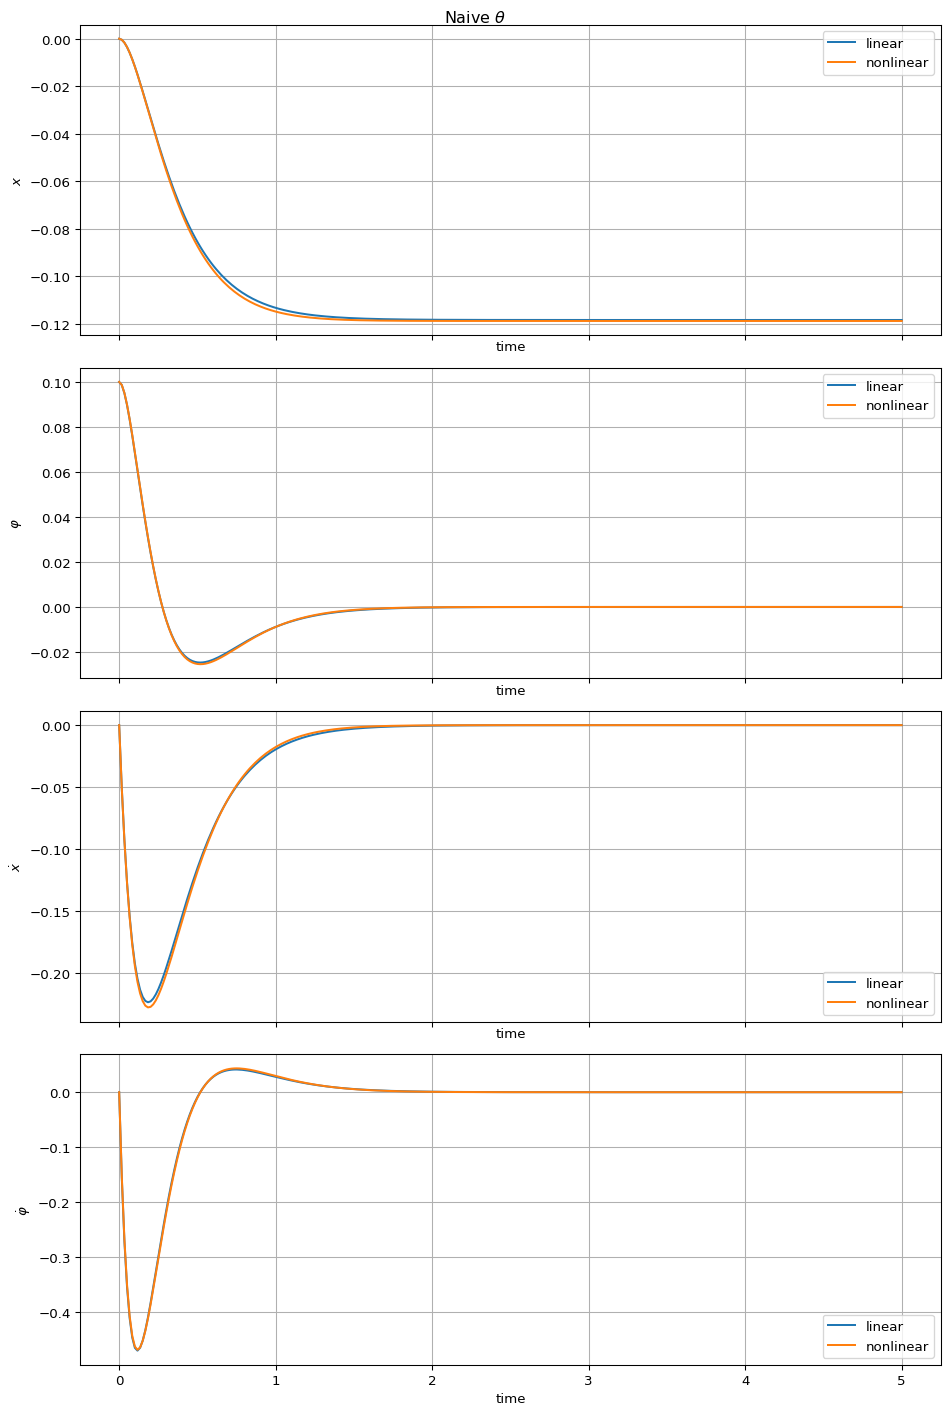

In [10]:
sol_nonlinear = solver(pend.nonlinear_system, theta_naive)
sol_linear = solver(pend.linear_system, pend.A, pend.b, theta_naive)

fig = gen_plot(time, [("linear", sol_linear), ("nonlinear", sol_nonlinear)], r"Naive $\theta$")
plt.show()

 ### Real $\theta$

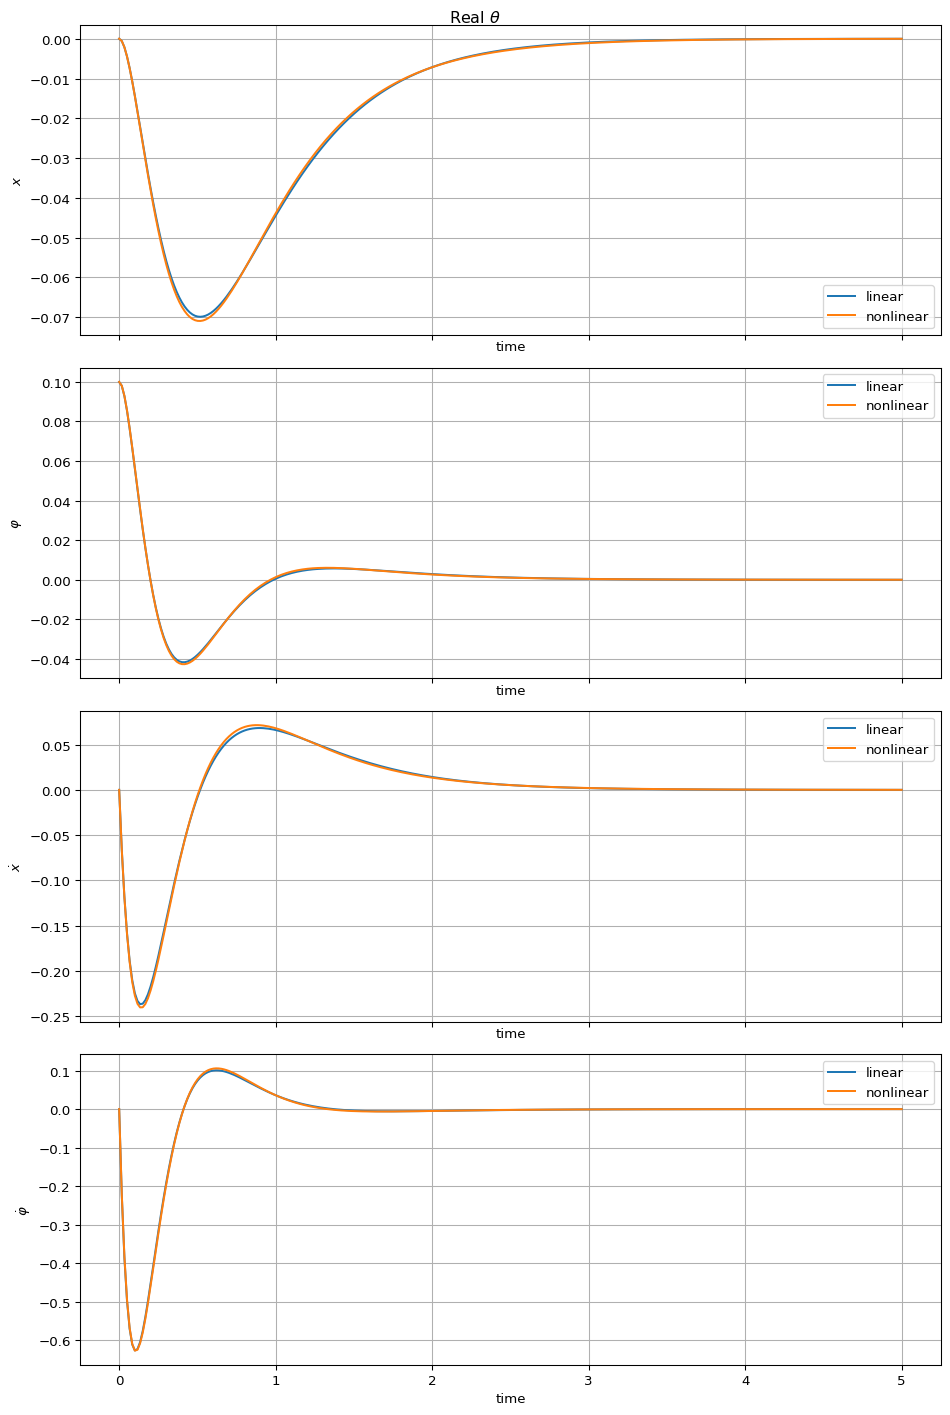

In [11]:
sol_nonlinear = solver(pend.nonlinear_system, theta_real)
sol_linear = solver(pend.linear_system, pend.A, pend.b, theta_real)

fig = gen_plot(time, [("linear", sol_linear), ("nonlinear", sol_nonlinear)], r"Real $\theta$")
plt.show()

 ### Complex $\theta$

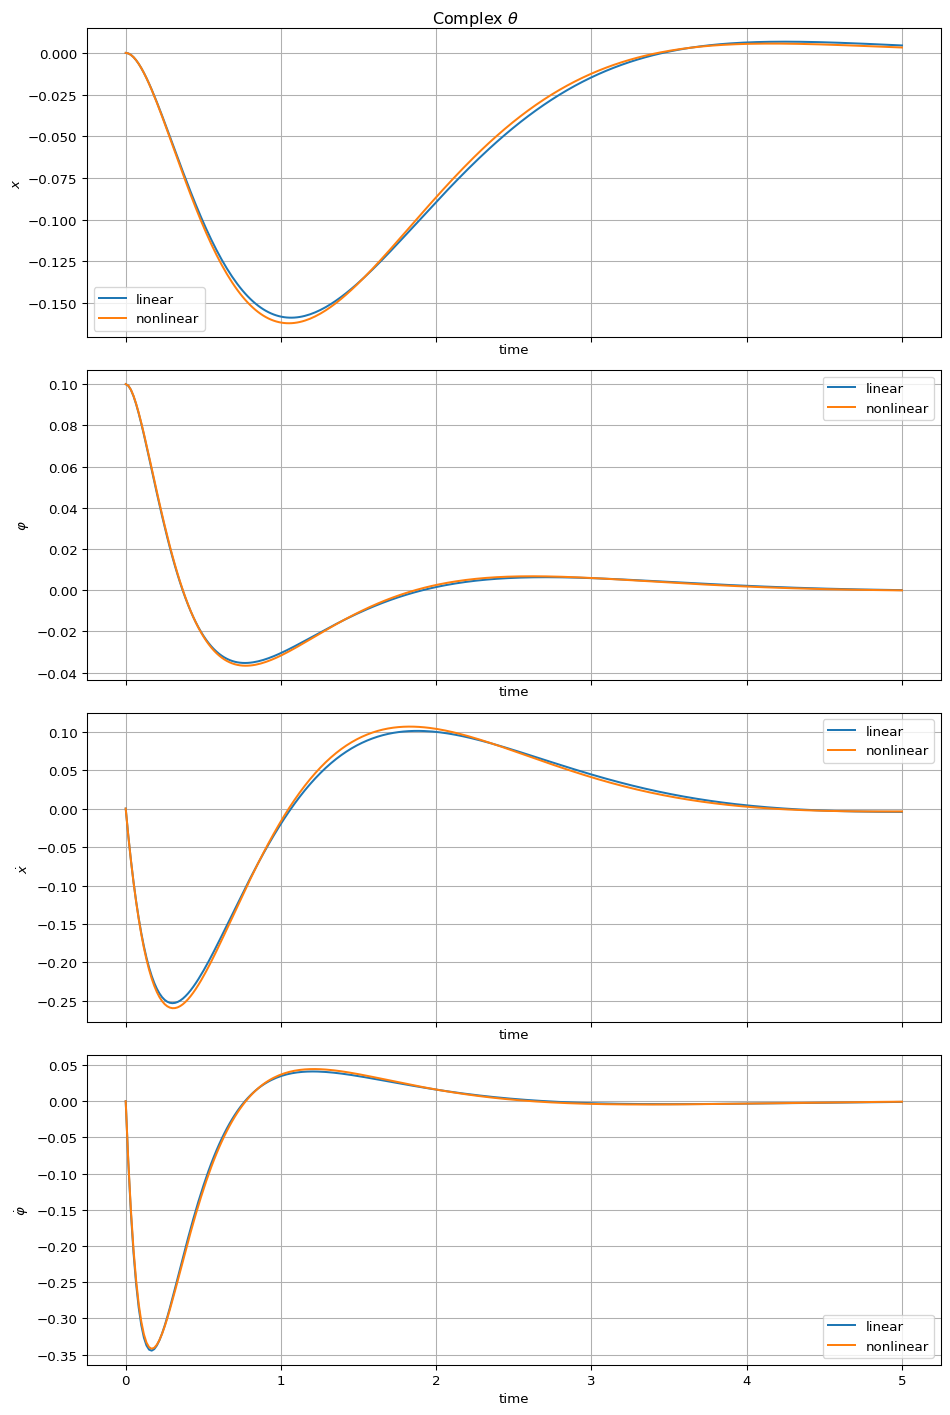

In [12]:
sol_nonlinear = solver(pend.nonlinear_system, theta_complex)
sol_linear = solver(pend.linear_system, pend.A, pend.b, theta_complex)

fig = gen_plot(time, [("linear", sol_linear), ("nonlinear", sol_nonlinear)], r"Complex $\theta$")
plt.show()

 # Синтез наблюдателя

In [13]:
O = create_control_mat(pend.A.T, pend.C.T)

print(f"O with shape {O.shape} and rank {np.linalg.matrix_rank(O)} = ")
pprint(O)

O with shape (4, 8) and rank 4 = 


⎡1.0   0    0    0     0        0       0        0   ⎤
⎢                                                    ⎥
⎢ 0   1.0   0    0    0.81    47.74    -3.9   -36.553⎥
⎢                                                    ⎥
⎢ 0    0   1.0   0   -4.386  -19.734  19.378  95.054 ⎥
⎢                                                    ⎥
⎣ 0    0    0   1.0  -0.007  -0.431   0.845    48.07 ⎦

In [14]:
eigvals, eigs = sp.linalg.eig(pend.A.T, right=False, left=True)
P_inv = np.vstack([
    eigs[:, 0],
    eigs[:, 3],
    np.array([0, 1, 0, 0]),
    np.array([0, 0, 1, 0]),
])
P = np.linalg.inv(P_inv)

print(f"Eigvals = {atos(eigvals.real)}")
print()
print(f"P^-1 = \n{atos(P_inv)}")
print()
print(f"P = \n{atos(P)}")

Eigvals = [ 6.598 -7.512 -3.902  0.   ]

P^-1 = 
[[-0.002 -0.15  -0.01  -0.989]
 [ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]]

P = 
[[ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]
 [-1.011 -0.002 -0.152 -0.011]]


In [15]:
A_hat = P_inv @ pend.A.T @ P
b_hat = P_inv @ pend.C.T

print(f"A_hat = \n{atos(A_hat)}")
print(f"b_hat = \n{atos(b_hat)}")

A_hat = 
[[  6.598  -0.     -0.     -0.   ]
 [  0.      0.      0.      0.   ]
 [-48.288  -0.076  -7.236   0.308]
 [ 19.961   1.031   2.991  -4.178]]
b_hat = 
[[-0.002 -0.15 ]
 [ 1.     0.   ]
 [ 0.     1.   ]
 [ 0.     0.   ]]


In [16]:
th_1 = sym.Symbol(r"theta_1")
th_2 = sym.Symbol(r"theta_2")

L_hat = np.array([
    [th_1, th_2, 0, 0],
    [th_1, th_2, 0, 0]
])

print(f"L_hat = ")
pprint(L_hat)

L_hat = 


⎡θ₁  θ₂  0  0⎤
⎢            ⎥
⎣θ₁  θ₂  0  0⎦

 $\hat A + \hat b \hat\theta = $

In [17]:
eq = A_hat + b_hat @ L_hat
pprint(eq)


⎡6.598 - 0.151⋅θ₁    -0.151⋅θ₂       0       0   ⎤
⎢                                                ⎥
⎢     1.0⋅θ₁           1.0⋅θ₂        0       0   ⎥
⎢                                                ⎥
⎢1.0⋅θ₁ - 48.288   1.0⋅θ₂ - 0.076  -7.236  0.308 ⎥
⎢                                                ⎥
⎣     19.961           1.031       2.991   -4.178⎦

In [18]:
A = np.array([
    [eq[0][0], eq[0][1]],
    [eq[1][0], eq[1][1]],
])

print("A = ")
pprint(A)

A = 


⎡6.598 - 0.151⋅θ₁  -0.151⋅θ₂⎤
⎢                           ⎥
⎣     1.0⋅θ₁        1.0⋅θ₂  ⎦

In [19]:
theta_real_L = find_theta(A, (-8, -2), th_1, th_2)
theta_real_L_non_asympt = find_theta(A, (-8, 0), th_1, th_2)
theta_complex_L = find_theta(A, (complex(-1, -1), complex(-1, 1)), th_1, th_2)

In [20]:
theta_hat_real = sym.Matrix(L_hat).subs([(th_1, theta_real_L[0]), (th_2, theta_real_L[1])])
theta_hat_real = np.array(theta_hat_real).astype(float)
L_real = (theta_hat_real @ P_inv).T

In [21]:
theta_hat_complex = sym.Matrix(L_hat).subs([(th_1, theta_complex_L[0]), (th_2, theta_complex_L[1])])
theta_hat_complex = np.array(theta_hat_complex).astype(complex)
L_complex = (theta_hat_complex @ P_inv).T

In [22]:
theta_hat_non_asympt = sym.Matrix(L_hat).subs([(th_1, theta_real_L_non_asympt[0]), (th_2, theta_real_L_non_asympt[1])])
theta_hat_non_asympt = np.array(theta_hat_non_asympt).astype(complex)
L_real_non_asympt= (theta_hat_non_asympt @ P_inv).T

In [23]:
pprint(np.linalg.eigvals(pend.A.T + pend.C.T @ L_real.T))

⎡ -2.0 ⎤
⎢      ⎥
⎢-3.902⎥
⎢      ⎥
⎢ -8.0 ⎥
⎢      ⎥
⎣-7.512⎦

In [24]:
pprint(np.linalg.eigvals(pend.A.T + pend.C.T @ L_complex.T))

⎡   -7.512   ⎤
⎢            ⎥
⎢   -3.902   ⎥
⎢            ⎥
⎢-1.0 + 1.0⋅ⅈ⎥
⎢            ⎥
⎣  -1.0 - ⅈ  ⎦

In [25]:
pprint(np.linalg.eigvals(pend.A.T + pend.C.T @ L_real_non_asympt.T))

⎡  0   ⎤
⎢      ⎥
⎢-3.902⎥
⎢      ⎥
⎢ -8.0 ⎥
⎢      ⎥
⎣-7.512⎦

In [26]:
solver, time = init_solve_system(np.array([0.1, 0, 0, 0, 0.7, 0, 0, 0]), stop=10)

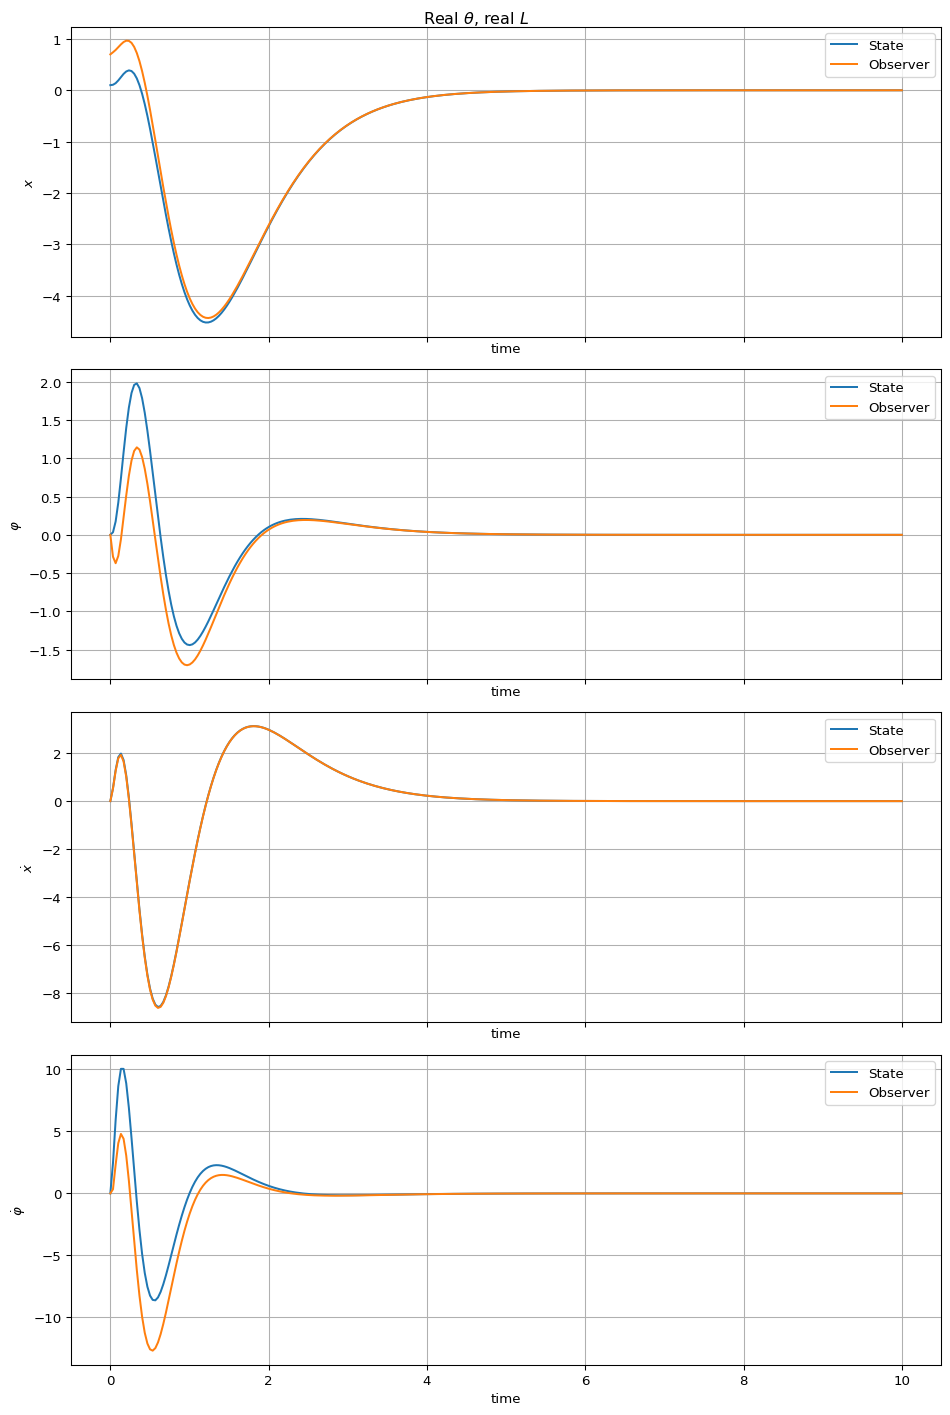

In [27]:
sol_observer = solver(pend.system_with_observer, pend.A, pend.b, pend.C, theta_real, -L_real)

fig = gen_plot(time, [("State", sol_observer[:4]), ("Observer", sol_observer[4:])], r"Real $\theta$, real $L$")
plt.show()

/media/data/repos/ct/.venv/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


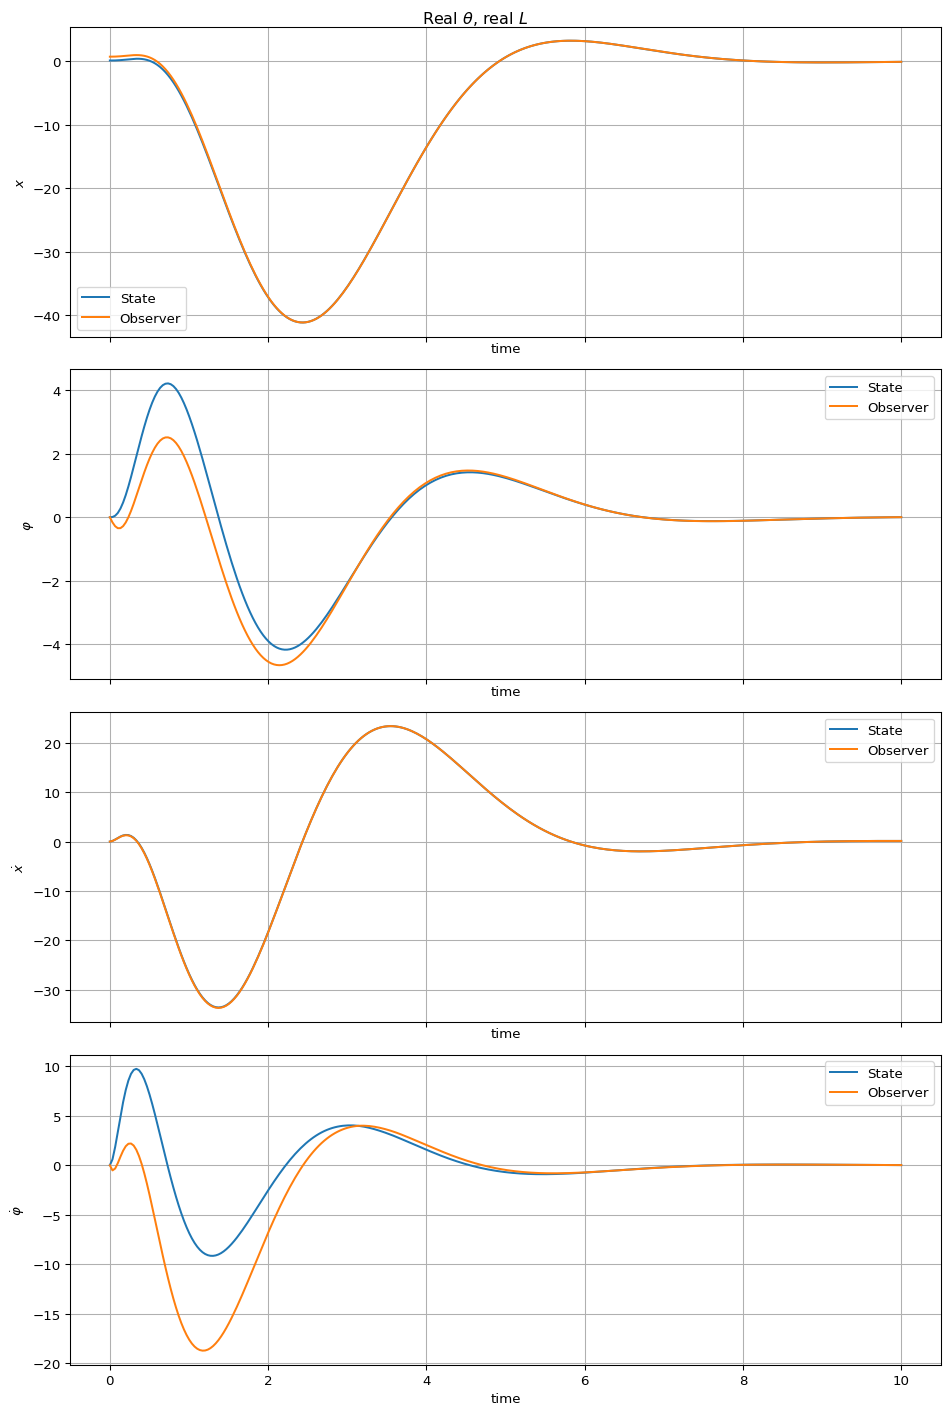

In [28]:
sol_observer = solver(pend.system_with_observer, pend.A, pend.b, pend.C, theta_complex, -L_complex)

fig = gen_plot(time, [("State", sol_observer[:4]), ("Observer", sol_observer[4:])], r"Real $\theta$, real $L$")
plt.show()

/media/data/repos/ct/.venv/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


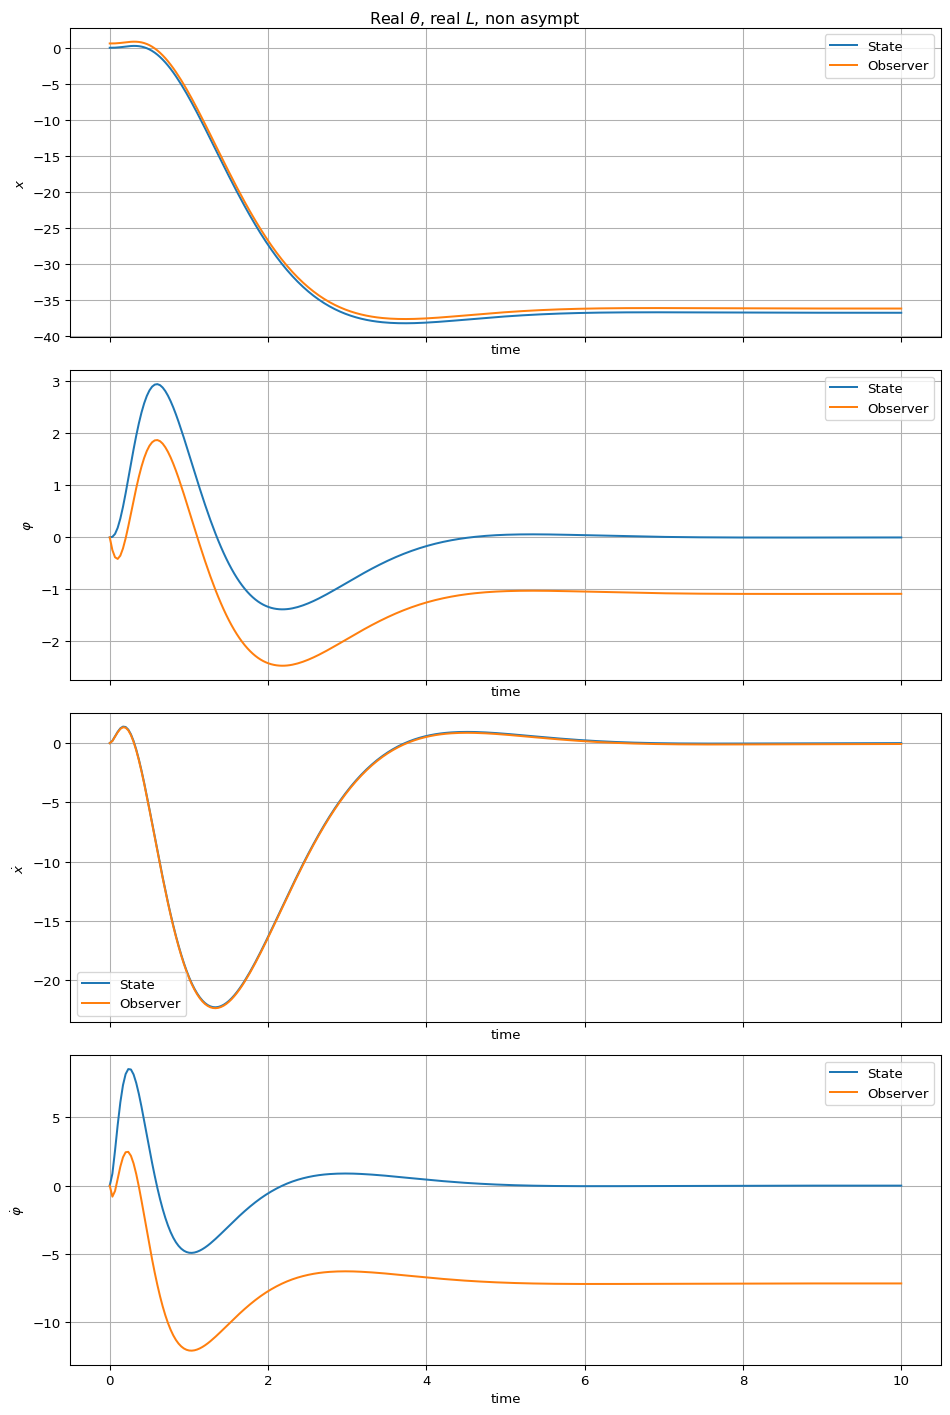

In [29]:
sol_observer = solver(pend.system_with_observer, pend.A, pend.b, pend.C, theta_complex, -L_real_non_asympt)

fig = gen_plot(time, [("State", sol_observer[:4]), ("Observer", sol_observer[4:])], r"Real $\theta$, real $L$, non asympt")
plt.show()